In [50]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [51]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 2.5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [52]:
CD4_variants = ['Ibalizumab', 'VKY91A', 'VKR95A', 'VHY99A']
CD4_on_rates = [2.1e5, 1.7e5, 3e5, 2.8e5]
CD4_off_rates = [1.8e-4, 4.2e-3, 1.6e-2, 2.e-2]

D_t = 5e-14
rtot=1e5
qon = 6.5e3
qoff = 4.7e-3
ftot= 2.2e5
D_f = 7.4e-14
A0s = np.geomspace(1e-12, 1e-5, 200)

rtot_synapse = rtot*tumour_cell_IS_proportion
ftot_synapse = ftot*NK_cell_IS_proportion

t_end = 60*60*6
t = np.geomspace(1e-10, t_end, 1000)
tspan = [1e-10, t_end]

In [53]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, ftot_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = ftot_synapse - z[2] - (z[3] + z[4])
    
    dA10 =   2*k1*(A0)*(rt) - k1off*z[0] - k2*1*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*1*z[0]*(rt) - 2*k1off*z[1] - k5*z[1]*(rf) + k2off*z[4]
    dA01 =  k3*(A0)*(rf) - k2off*z[2] - 2*1*k6*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*1*k6*z[2]*(rt) - k1off*z[3] - 1*k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - k2off*z[4] + 1*k7*z[3]*(rt) - 2*k1off*1*z[4]
    
    dz = [dA10, dA20, dA01, dA11, dA21]
    return np.asarray(dz, dtype="object")

In [54]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-3], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A11_prop = A1_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A21_prop = A2_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A11_approx += A11_prop*A1_synapse
    A21_approx += A1_synapse*A21_prop
    A10_approx += (A1_pre_synapse - A11_approx)
    A20_approx += (A2_pre_synapse - A21_approx)
    sol_guess += A11_approx + 2*A21_approx
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks + A1_E_stst) , k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [55]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area


    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    
    Atot = A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = np.asarray([A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0], dtype='object')
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = 2*(D_t +D_f)/(synapse_area)  
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF', atol=1e-5, rtol=1e-5,  t_eval=t, args=np.asarray([k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot], dtype='object'))
    print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = A11[-1] + A21[-1]
    
    
    return crosslinks

In [56]:

crosslinks = np.zeros((len(CD4_on_rates), len(A0s)))

for i, kon in enumerate(CD4_on_rates):
   
    koff = CD4_off_rates[i]

    for j, Ainit in enumerate(A0s):
        
        crosslinks[i, j] = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)


The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached th

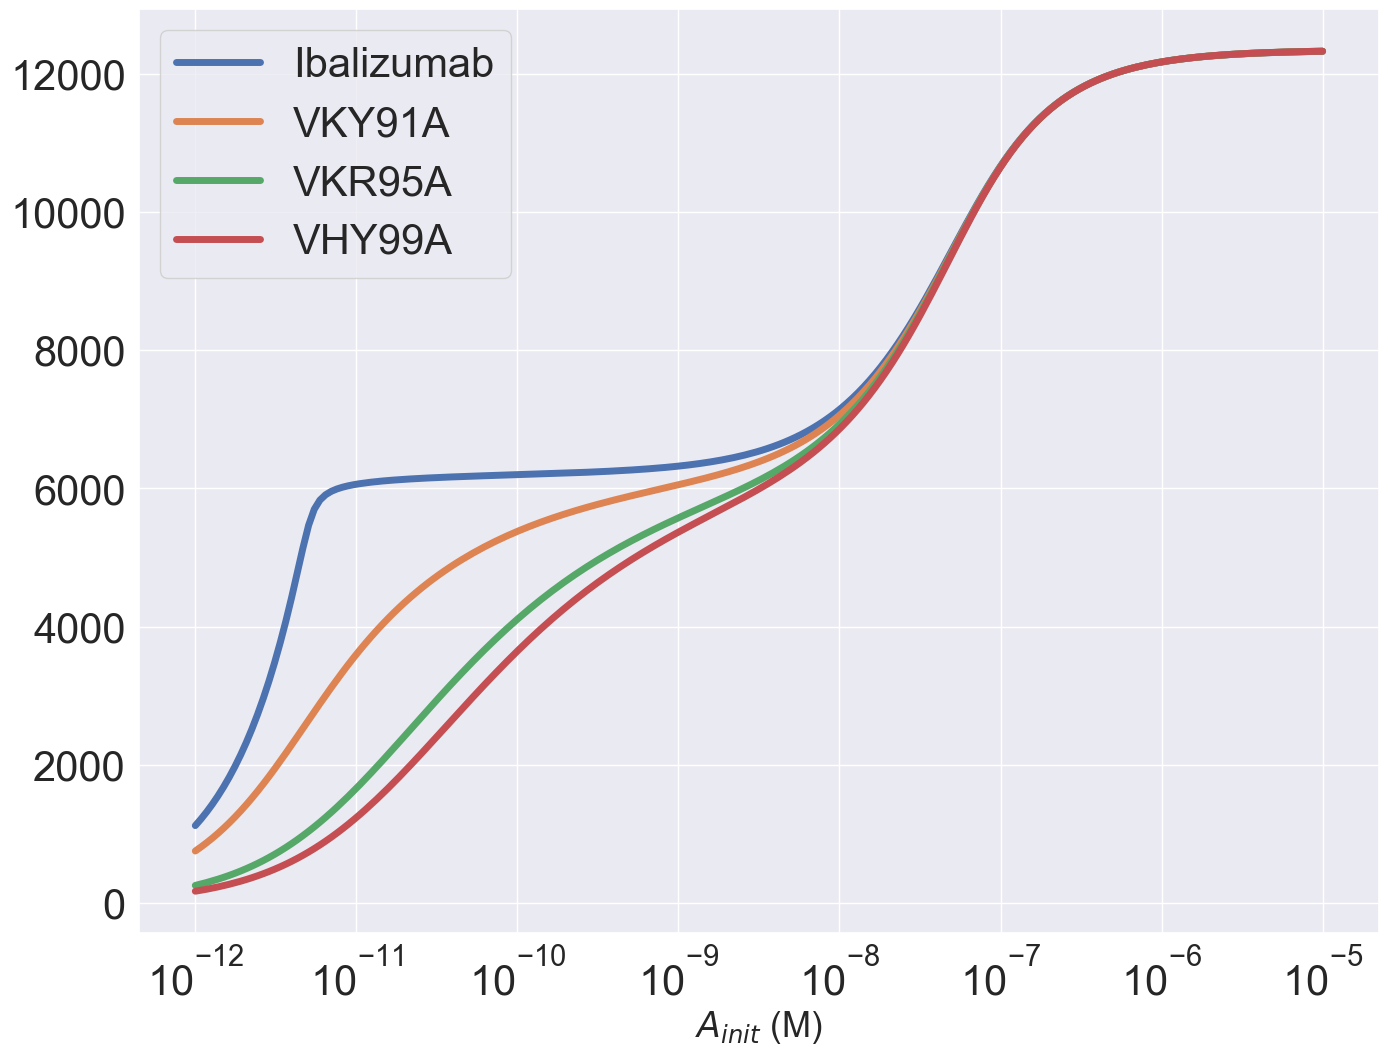

In [57]:
sns.set_context('talk')
sns.set_theme()
fig, ax = plt.subplots(figsize=(16, 12))
for i in range(len(CD4_on_rates)):
    ax.semilogx(A0s, crosslinks[i, :], label=CD4_variants[i], lw=5)

ax.tick_params(labelsize=30)
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=25)
plt.show()